# Test InceptionV3 model
Let's look at how well Inception v3 models classsify genres through posters only!

## Load data and libraries

In [42]:
# Install Keras version 2.3.1
!pip install -q tensorflow scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.3 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np

In [4]:
# # only run this once!
# from google.colab import drive

# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import io

ZIP_FILE_PATH = "drive/MyDrive/personal_projects/movie_genre_prediction/clean_data.zip"
zf = zipfile.ZipFile(ZIP_FILE_PATH, "r")
zf.extractall()

In [8]:
big_data_df = pd.read_csv('raw_data/clean_data/clean_big_data.csv').drop(columns=['Unnamed: 0'])
big_data_df.head(1)

,imdb_id,genre,plot
0,tt1517268,"['Adventure', 'Comedy', 'Fantasy']",barbie suffers a crisis that leads her to ques...


In [9]:
image_array = np.load('raw_data/clean_data/clean_image_array.npy')
image_array.shape

(23140, 256, 256, 3)

## Preprocess Targets (Genres) and Split the Dataset Into train, val, test!

In [10]:
def preprocess_genre(df: pd.DataFrame):
    df["genre"] = df["genre"].apply(eval).apply(lambda x: [genre.strip() for genre in x])
    return df

In [11]:
big_data_df = preprocess_genre(big_data_df)
big_data_df.head(1)

,imdb_id,genre,plot
0,tt1517268,"[Adventure, Comedy, Fantasy]",barbie suffers a crisis that leads her to ques...


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

# Multilabel_binarizer is fit to an array of list of labels
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(big_data_df['genre'])

#transform target variable
y = multilabel_binarizer.transform(big_data_df['genre'])
genre_names = multilabel_binarizer.classes_

# Adding the name of genres
for i in range(len(genre_names)):
    big_data_df[f"{genre_names[i]}"] = y[:,i]

print(y.shape, big_data_df.shape)

(23140, 22) (23140, 25)


In [15]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df: pd.DataFrame, labels: np.array, image_array: np.array, test_size=0.5):
    """
    index_array: an array of our current df index,
    iterative_train_test_split: a function that considers the distribution of possible labels when splitting
    """
    index_array = np.expand_dims(np.arange(len(df)), axis=1)
    train_index, y_train, test_index, y_test = iterative_train_test_split(index_array, labels, test_size)
    train_image_array, test_image_array = np.take(image_array, train_index.ravel(), axis=0), np.take(image_array, test_index.ravel(), axis=0)
    return df.iloc[train_index[:, 0]], train_image_array, y_train, df.iloc[test_index[:, 0]], test_image_array, y_test

In [16]:
# Split dataset to train and test_val (will split test and val again!)
train_df, train_image_array, y_train, test_val_df, test_val_image_array, y_test_val = balanced_split(big_data_df, y, image_array, 0.3)
print(
    train_df.shape,
    y_train.shape,
    train_image_array.shape,
    test_val_df.shape,
    test_val_image_array.shape,
    y_test_val.shape
    )

(16278, 25) (16278, 22) (16278, 256, 256, 3) (6862, 25) (6862, 256, 256, 3) (6862, 22)


In [17]:
# Split test_val further to test and val datasets!
test_df, test_image_array, y_test, val_df, val_image_array, y_val = balanced_split(test_val_df, y_test_val, test_val_image_array)
print(
    test_df.shape,
    test_image_array.shape,
    y_test.shape,
    val_df.shape,
    val_image_array.shape,
    y_val.shape
    )

(3430, 25) (3430, 256, 256, 3) (3430, 22) (3432, 25) (3432, 256, 256, 3) (3432, 22)


# Inception v3 model

In [58]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2, l1

from tensorflow.keras.optimizers import Adam, SGD, Adadelta

In [45]:
input_shape = train_image_array[0].shape
n_classes = y_train.shape[1]

In [88]:
#Model that enable the freezing of the resnet layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
x = base_model.output
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Dropout(.4)(x)
x = Flatten()(x)

predictions = Dense(n_classes,
                    activation='relu')(x)

model = Model(inputs=base_model.input, outputs=predictions)


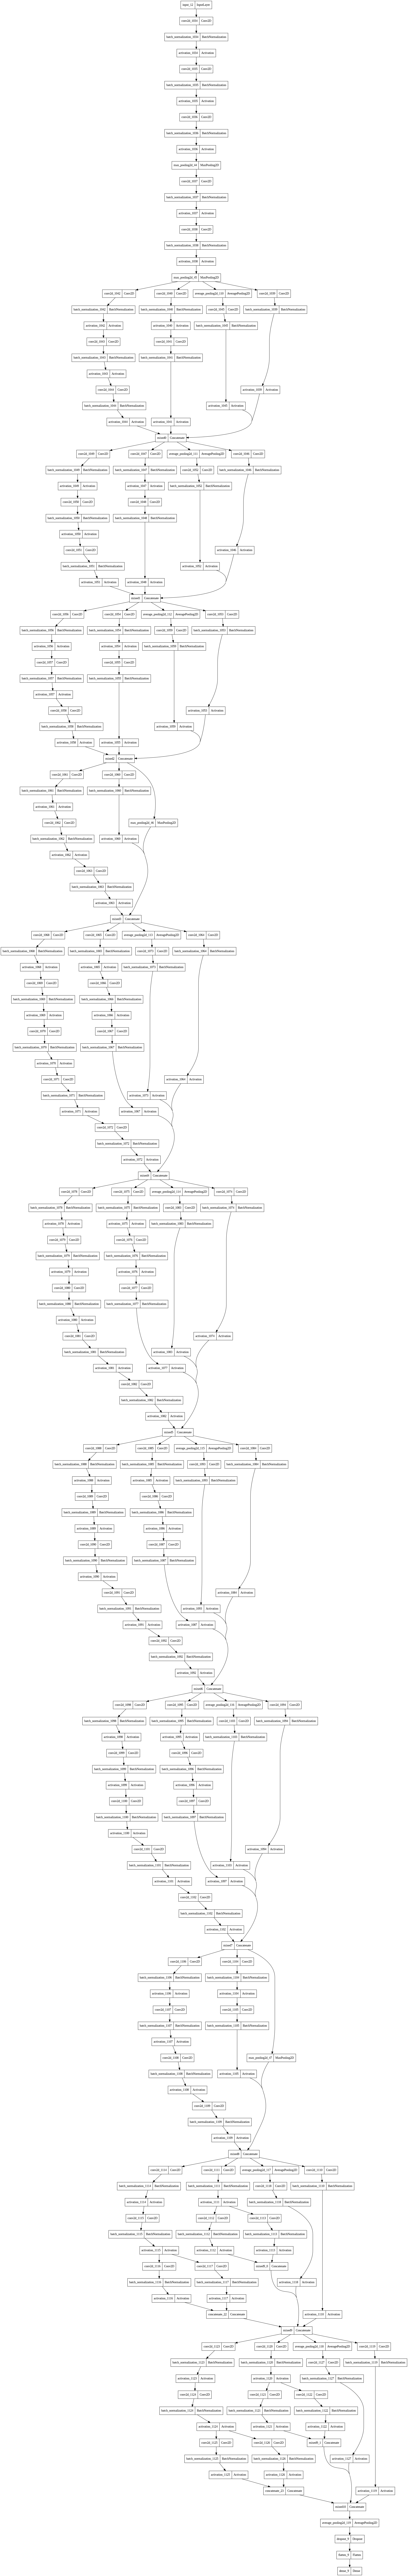

In [89]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [90]:
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [91]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [92]:
# Setup callbacks and logs
checkpoint_path = "InceptionV3/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
cp = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',save_best_only=True,verbose=1, mode='max')
csv_logger = CSVLogger('InceptionV3/InceptionV3.log')

In [93]:
# Reduce LR if no improvement on the test accuracy is observed
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=2, min_lr=0.00001)

In [94]:
from tensorflow import convert_to_tensor

In [98]:
#Fitting
batch_size = 8
model.fit(x=train_image_array,
          y=convert_to_tensor(y_train),
          validation_data=(val_image_array, convert_to_tensor(y_val)),
          epochs=10,
          verbose=1,
          callbacks=[cp]
          )

Epoch 1/10
509/509 [==============================] - ETA: 0s - loss: 0.9810 - accuracy: 0.2113
Epoch 1: val_accuracy improved from -inf to 0.20192, saving model to InceptionV3/weights-improvement-01-0.20.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


509/509 [==============================] - 250s 393ms/step - loss: 0.9810 - accuracy: 0.2113 - val_loss: 0.7472 - val_accuracy: 0.2019
Epoch 2/10
509/509 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.2142
Epoch 2: val_accuracy improved from 0.20192 to 0.20629, saving model to InceptionV3/weights-improvement-02-0.21.hdf5
509/509 [==============================] - 194s 381ms/step - loss: 0.6565 - accuracy: 0.2142 - val_loss: 0.6133 - val_accuracy: 0.2063
Epoch 3/10
509/509 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.2139
Epoch 3: val_accuracy did not improve from 0.20629
509/509 [==============================] - 192s 377ms/step - loss: 0.6030 - accuracy: 0.2139 - val_loss: 0.6014 - val_accuracy: 0.2063
Epoch 4/10
509/509 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.2146
Epoch 4: val_accuracy improved from 0.20629 to 0.20833, saving model to InceptionV3/weights-improvement-04-0.21.hdf5
509/509 [=============